<a href="https://colab.research.google.com/github/jnramirezg/medio_continuo/blob/main/codigo/31-analisis_viga_simplemente_apoyada_airy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis viga simplemente apoyada con Airy (sección 5.8)

|Quién | Fecha | Qué hizo |
| ---  | ---   | ---      |
|Juan Nicolás Ramírez, <jnramirezg@unal.edu.co> | 2022-11-22 | Conversión de código de MAXIMA a Python|

[Código original](https://github.com/diegoandresalvarez/solidos/blob/master/archivos/codigo/cap_05/5.08_viga_simplemente_apoyada_Airy.mac)

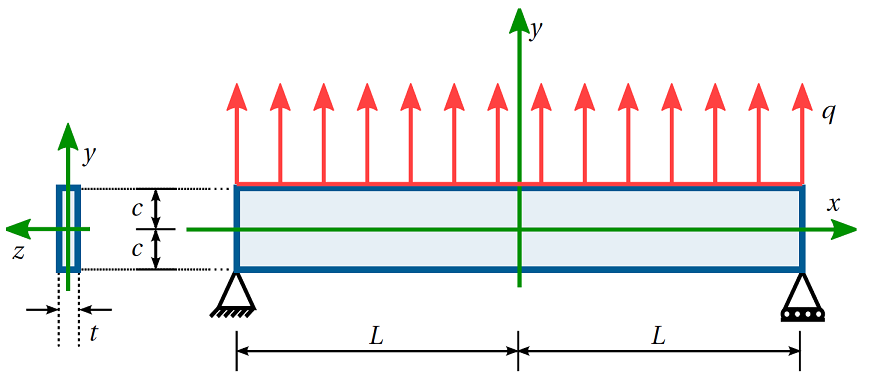

Importamos las librerias y funciones necesarias:

In [1]:
from sympy import symbols, diff, integrate, solve, factor, expand, collect, Rational, Add
import sympy as sp

# Para imprimir bonito
sp.init_printing()
from IPython.display import Math                 
def imprimir (texto, variable):
    return Math(texto +  rf'{sp.latex(variable)}')

Creamos las variables simbólicas:

In [2]:
x, y, z = symbols("x,y,z")                       # Coordenadas.
A20, A21, A03, A23 = symbols("A20,A21,A03,A23")  # Constantes de la función de tensión de Airy.
K2 = symbols("K_2")                              # Conste de TP o DP de la ecuación biarmónica.
c, L, q = symbols("c,L,q")                       # Propiedades de la viga.
E, nu = symbols("E, nu")                         # Propiedades del material.
u0, v0, w0 = symbols("u0, v0, omega_0")          # Constante de integración.

In [3]:
t = 1  # [m]: espesor.
V = 0  # V=0, ya que no se considerarán las fuerzas másicas.

Proponemos la función de tensión de Airy:

In [4]:
phi = A20*x**2 + A21*x**2*y + A03*y**3 + A23*x**2*y**3 - A23*y**5/5
imprimir(r"\phi(x,y) = ", phi)

<IPython.core.display.Math object>

Definimos el laplaciano y el biarmónico de una función $f$:

In [5]:
lapl = lambda f: diff(f,x,2) + diff(f,y,2)
biar = lambda f: lapl(lapl(f))

Verificamos que se satisfaga la ecuación $\nabla^4\phi=K_2\nabla^2V$

In [6]:
if biar(phi) - K2*lapl(V) == 0:
    print("La ecuación biarmónica se satisface.")
else:
    print("La ecuación NO biarmónica se satisface.")

La ecuación biarmónica se satisface.


Definimos los esfuerzos utilizando la función de tensión de Airy:
$$\sigma_x(x,y)=\frac{\partial^2 \phi(x,y)}{\partial y^2} + V(x,y)$$
$$\sigma_x(x,y)=\frac{\partial^2 \phi(x,y)}{\partial x^2} + V(x,y)$$
$$\tau_{xy}(x,y)=-\frac{\partial^2 \phi(x,y)}{\partial x \partial y}$$

In [7]:
sx  =  diff(phi, y,2) + V
sy  =  diff(phi, x,2) + V
txy = -diff(phi, x,1, y,1)

Definimos la fuerza cortante, el momento flector y la fuerza axial:
$$V(x) = -\int_{-c}^{c}\int_{0}^{t}{\tau_{xy}(x,y,z)}dzdy$$
$$M(x) = -\int_{-c}^{c}\int_{0}^{t}{y\sigma_x(x,y,z)}dzdy$$
$$f_{axial}(x) = -\int_{-c}^{c}\int_{0}^{t}{\sigma_x(x,y,z)}dzdy=0$$

In [8]:
V   = lambda xx: -integrate(txy.subs(x,xx),   (z,0,t), (y,-c,c))
M   = lambda xx: -integrate( sx.subs(x,xx)*y, (z,0,t), (y,-c,c))
fax =             integrate( sx,              (z,0,t), (y,-c,c))

Establecemos las condiciones de frontera:

In [9]:
e1 = txy.subs(y, +c) - 0    # =0
e2 = txy.subs(y, -c) - 0    # =0
e3 =  sy.subs(y, +c) - q/t  # =0
e4 =  sy.subs(y, -c) - 0    # =0

e5 = V(-L) - (-q*L)  # =0
e6 = V(+L) - (+q*L)  # =0
e7 = M(-L) - 0        # =0
e8 = M(+L) - 0        # =0
e9 = fax   - 0        # =0 para todo x en [−L, L]

Utilizando las ecuaciones ```e1``` a ```e9``` encontramos las constantes ```A20```, ```A21```, ```A03``` y ```A23```:

In [10]:
A20210323 = solve([e1,e2,e3,e4,e5,e6,e7,e8,e9], [A20,A21,A03,A23])

Reemplazamos ```A20```, ```A21```, ```A03``` y ```A23``` en los esfuerzos ```sx```, ```sy``` y ```txy```:

In [11]:
sx  = sx.subs(A20210323)
imprimir(r"\sigma_x=", factor(sx,q))

<IPython.core.display.Math object>

In [12]:
sy  = sy.subs(A20210323)
imprimir(r"\sigma_y=", collect(sy,2*c-y))

<IPython.core.display.Math object>

In [13]:
txy = txy.subs(A20210323)
imprimir(r"\tau_{xy}=", factor(expand(txy),q))

<IPython.core.display.Math object>

Se compara la solución obtenida con las ecuaciones (4.45):

In [14]:
Ib = 2*t*c**3/3
sx2  = -(q/(2*Ib))*(x**2*y - 2*y**3/3 + 2*c**2*y/5 - L**2*y)
sy2  = -(q/(2*Ib))*(y**3/3 - c**2*y - 2*c**3/3)
txy2 = -(q/(2*Ib))*(c**2 - y**2)*x

El resultado de la siguiente línea es [0, 0, 0]:

In [15]:
factor([sx-sx2, sy-sy2, txy-txy2])

Definimos el módulo de cortante:

In [16]:
G = E/(2*(1+nu))

Usamos las ecuaciones de ley de Hooke de tensión plana para isótropos para calcular las deformaciones:

In [17]:
ex  = (1/E)*(sx - nu*sy)
imprimir(r"\varepsilon_x=", factor(ex, -q))

<IPython.core.display.Math object>

In [18]:
ey  = (1/E)*(sy - nu*sx)
imprimir(r"\varepsilon_y=", factor(ey))

<IPython.core.display.Math object>

In [19]:
gxy = (1/G)*txy
imprimir(r"\gamma_{xy}=", factor(gxy))

<IPython.core.display.Math object>

De las ecuaciones:

$$u(x,y)=\int\varepsilon_x(x',y)dx'+f(y)$$
$$v(x,y)=\int\varepsilon_y(x,y')dy'+g(x)$$
$$\frac{\partial f(y)}{\partial y} + \frac{\partial g(x)}{\partial x}=\gamma_{xy}(x,y)-\frac{\partial}{\partial y}\left( \int\varepsilon_x(x',y)dx'\right) -\frac{\partial}{\partial x}\left(\int\varepsilon_y(x,y')dy' \right)$$

Usamos la tercera ecuación:

In [20]:
df_dy_dg_dx = gxy - diff(integrate(ex,x),y) - diff(integrate(ey,y),x)
imprimir(r"\frac{\partial f(y)}{\partial y}+\frac{\partial g(x)}{\partial x}=", 
         factor(df_dy_dg_dx))

<IPython.core.display.Math object>

In [21]:
df_dy_dg_dx = gxy - diff(integrate(ex,x),y) - diff(integrate(ey,y),x)
imprimir(r"\frac{\partial f(y)}{\partial y}+\frac{\partial g(x)}{\partial x}=", 
         factor(df_dy_dg_dx))

<IPython.core.display.Math object>

Descomponemos la ecuación diferencial en:
$$\frac{\partial f(y)}{\partial y} + \omega_0=0$$
$$\frac{\partial g(x)}{\partial x} - \omega_0=0$$

In [22]:
df_dy = df_dy_dg_dx.subs(x,0) + w0
imprimir(r"\frac{\partial f(y)}{\partial y}=", df_dy)

<IPython.core.display.Math object>

In [23]:
dg_dx = factor(df_dy_dg_dx.subs(y,0)) - w0
imprimir(r"\frac{\partial g(x)}{\partial x}=", dg_dx)

<IPython.core.display.Math object>

De esta forma:

$$\displaystyle \frac{\partial f(y)}{\partial y}+\frac{\partial g(x)}{\partial x}= \underbrace{\omega_0}_{\frac{\partial f(y)}{\partial y}} + \underbrace{\frac{q x \left(- 15 L^{2} - 15 c^{2} \nu - 24 c^{2} + 5 x^{2}\right)}{20 E c^{3}} - \omega_0}_{\frac{\partial g(x)}{\partial x}}$$


Ahora, calculamos ```f``` y ```g``` (sin considerar aún sus constantes de integración):

In [24]:
f = integrate(df_dy, y)
imprimir(r"f(y)=",f)

<IPython.core.display.Math object>

In [25]:
g = integrate(dg_dx, x)
imprimir(r"g(x)=",expand(g))

<IPython.core.display.Math object>

Finalmente, calculamos los desplamientos ```u``` y ```v``` (con las constantes de integración u0 y v0, que consideran el aporte de ```f``` y ```g```):

In [26]:
u = integrate(ex, x) + f + u0
v = integrate(ey, y) + g + v0

Sólo resta encontrar los valores de ```u0```, ```v0``` y ```w0``` a partir de las condiciones de frontera y el conocimiento que en el centro de la viga el desplazamiento horizontal es nulo:

In [27]:
e1 = u.subs([(x, 0)])       - 0  # =0
e2 = v.subs([(x,+L),(y,0)]) - 0  # =0
e3 = v.subs([(x,-L),(y,0)]) - 0  # =0

In [28]:
u0v0w0 = solve([e1,e2,e3],[u0, v0, w0])

Donde las constantes de integración son:

In [29]:
imprimir(r"u_0=", u0v0w0[u0])

<IPython.core.display.Math object>

In [30]:
imprimir(r"v_0=", collect(u0v0w0[v0],q*L**2))

<IPython.core.display.Math object>

In [31]:
imprimir(r"\omega_0=", u0v0w0[w0])

<IPython.core.display.Math object>

Reemplazamos las constantes de integración:

In [32]:
u = u.subs(u0v0w0)
v = v.subs(u0v0w0)

Obtenemos los desplazamientos de la viga:

In [33]:
imprimir(r"u(x,y) = ", factor(u, -q))

<IPython.core.display.Math object>

In [34]:
imprimir(r"v(x,y) = ", v)

<IPython.core.display.Math object>

Por último, la deflexión vertical de la viga en el punto $x=0$, $y=0$ es:

In [35]:
v_0_0 = v.subs([(x,0), (y,0)])
imprimir(r"v(0,0) = ", v_0_0)

<IPython.core.display.Math object>

Reemplazamos $\frac{2tc^3}{3}$ por $I$:

In [36]:
I=symbols("I")
v_0_0 = v_0_0*Ib/I  # Es equivalente a multiplicar por uno.

Primera forma de factorizar la expresión:

In [37]:
ec1 = Add(expand(v_0_0/(Rational(5,24)*q*L**4/(E*I))) * (Rational(5,24)*q*L**4/(E*I)),
          evaluate=False)
imprimir(r"v(0,0) =", ec1)

<IPython.core.display.Math object>

Segunda forma de factorizar la expresión:

In [38]:
_2L= symbols("(2L)")
ec2 = collect(ec1.subs(L, _2L/2).subs(c**2/_2L**2, c**2/((2*L)**2)),
              c**2/L**2)
imprimir(r"v(0,0) =", ec2)

<IPython.core.display.Math object>

En este caso, el parámetro $h/L$ viene representado de forma equivalente por $c/L$. Por lo tanto, el % de variación respecto a la teoría de Euler-Bernoulli (revisar [este programa](https://github.com/jnramirezg/medio_continuo/blob/main/codigo/28-analisis_viga_simplemente_apoyada.ipynb)) viene dada por:
$$\left(\frac{6\nu}{5}+\frac{48}{25}\right)\left(\frac{c}{L}\right)^2$$

Suponiendo $\nu=0.3$, por ejemplo, para $c/L=[0.05, 0.1, 0.25]$:

In [39]:
nu=0.3

In [40]:
c_L=0.05
(6*nu/5+48/25)*(c_L)**2

In [41]:
c_L=0.1
(6*nu/5+48/25)*(c_L)**2

In [42]:
c_L=0.25
(6*nu/5+48/25)*(c_L)**2